Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/hero/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [04:56:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/hero/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [04:56:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/hero/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [04:56:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/hero/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [04:56:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

✅ Best Parameters:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

🎯 Accuracy: 0.80


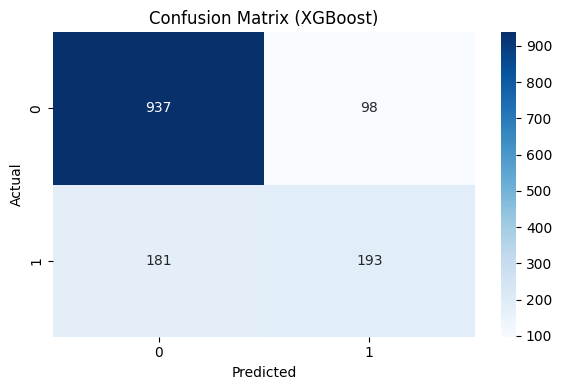

💾 Model saved to '../models/churn_model.pkl'


In [2]:
# 03_model_training.ipynb

import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

# Step 1: Ensure output folders exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

# Step 2: Load preprocessed data
df = pd.read_csv('../data/processed/processed_data.csv')
X = df.drop(columns='churn')
y = df['churn']

# Step 3: Identify column types
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 4: Preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  # numeric features are used as-is
)

# Step 5: Build ML pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Step 6: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 7: GridSearchCV for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.1, 0.01]
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=3, n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

# Step 8: Evaluate the best model
y_pred = grid_search.predict(X_test)

print("✅ Best Parameters:")
print(grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"🎯 Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Step 9: Save confusion matrix plot
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrix_xgboost.png')
plt.show()

# Step 10: Save the trained model
joblib.dump(grid_search.best_estimator_, '../models/churn_model.pkl')
print("💾 Model saved to '../models/churn_model.pkl'")
